In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class MACDBacktester(): 
    ''' Class for the vectorized backtesting of MACD-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    signal_mw: int
        time window is days for MACD Signal 
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets new MACD parameter(s)
        
    test_strategy:
        runs the backtest for the MACD-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates MACD parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the three MACD parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, signal_mw, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.signal_mw = signal_mw
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "MACDBacktester(symbol = {}, MACD({}, {}, {}), start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
        raw["MACD"] = raw.EMA_S - raw.EMA_L
        raw["MACD_Signal"] = raw.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean() 
        self.data = raw
      
        
    def set_parameters(self, EMA_S = None, EMA_L = None, signal_mw = None):
        ''' Updates MACD parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if signal_mw is not None:
            self.signal_mw = signal_mw
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["MACD"] > data["MACD_Signal"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | MACD ({}, {}, {}) | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, MACD):
        ''' Updates MACD parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        MACD: tuple
            MACD parameter tuple
        '''
        self.set_parameters(int(MACD[0]), int(MACD[1]), int(MACD[2]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA_S_range, EMA_L_range, signal_mw_range):
        ''' Finds global maximum given the MACD parameter ranges.

        Parameters
        ==========
        EMA_S_range, EMA_L_range, signal_mw_range : tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA_S_range, EMA_L_range, signal_mw_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [4]:
tester = MACDBacktester("EURUSD=X", EMA_S = 12, EMA_L = 26, signal_mw = 9, start = "2004-01-01", end = "2020-06-30", tc = 0.0007)

In [5]:
tester

MACDBacktester(symbol = EURUSD=X, MACD(12, 26, 9), start = 2004-01-01, end = 2020-06-30)

In [6]:
tester.test_strategy()

(0.259076, -0.615653)

In [7]:
tester.results

,price,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2004-02-18,1.272508,-0.010386,1.271449,1.266693,0.004756,0.003408,1,-0.010386,0.0,0.989667,0.989667
2004-02-19,1.275705,0.002510,1.272106,1.267405,0.004700,0.003691,1,0.002510,0.0,0.992154,0.992154
2004-02-20,1.254202,-0.017000,1.269345,1.266367,0.002978,0.003538,-1,-0.018400,2.0,0.975430,0.974065
2004-02-23,1.257197,0.002386,1.267473,1.265649,0.001824,0.003175,-1,-0.002386,0.0,0.977760,0.971744
2004-02-24,1.267797,0.008395,1.267523,1.265817,0.001706,0.002868,-1,-0.008395,0.0,0.986003,0.963620
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.125123,1.117852,0.007272,0.008516,-1,-0.002892,0.0,0.879795,0.257584
2020-06-25,1.125087,-0.005449,1.125118,1.118388,0.006730,0.008158,-1,0.005449,0.0,0.875014,0.258991
2020-06-26,1.122208,-0.002562,1.124670,1.118671,0.005999,0.007727,-1,0.002562,0.0,0.872775,0.259655


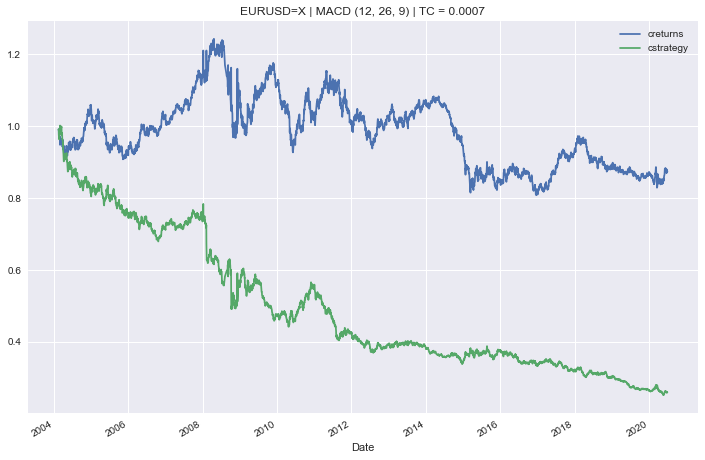

In [8]:
tester.plot_results()

In [9]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([18., 30., 19.]), 0.583754)

In [10]:
tester.test_strategy()

(0.583754, -0.321376)

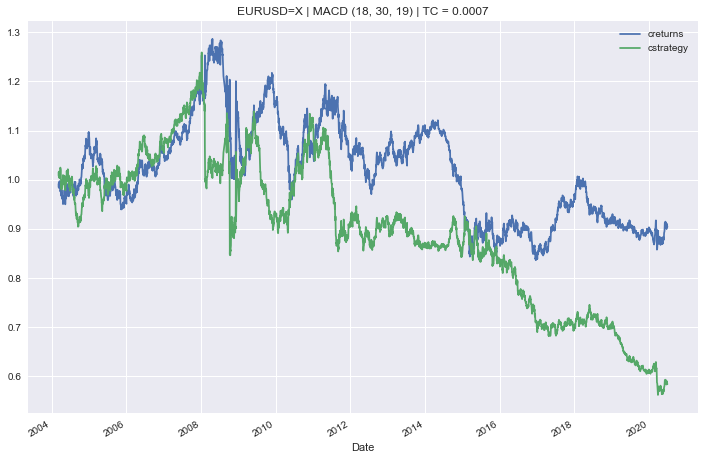

In [12]:
tester.plot_results()